<a href="https://colab.research.google.com/github/HishamAhmed2/Neuromatch-academy-project/blob/master/Neuromatch_academy_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


# **Data**

Data from Steinmetz et al, 2019. The mouse is surrounded by three computer screens and the mouse has a wheel that he can turn left or right and a tube through which a drop of water is given to him when he answers correctly and there was two stimulus location on each of right and left screen and stimulus could be on one, the other, both or neither screen. if the stimulus was higher contrast on the right he should turn the wheel counterclockwise and if the stimulus was higher contrast on the left he should turn the wheel clockwise and if the stimulus was equal on both sides he had to stay still for 1.5 second and visual stimulus move on the screen as he moves the wheel and his goal is to bring the high contrast visual stimulus to the screen in the center. Time bins for all measurements are 10ms, starting 500ms before stimulus onset.

# Response time when contrast difference = 0

**conclousion**: when contrast difference equal 0 mice respond sometimes fast and sometimes slow

Text(0, 0.5, 'contrast_difference')

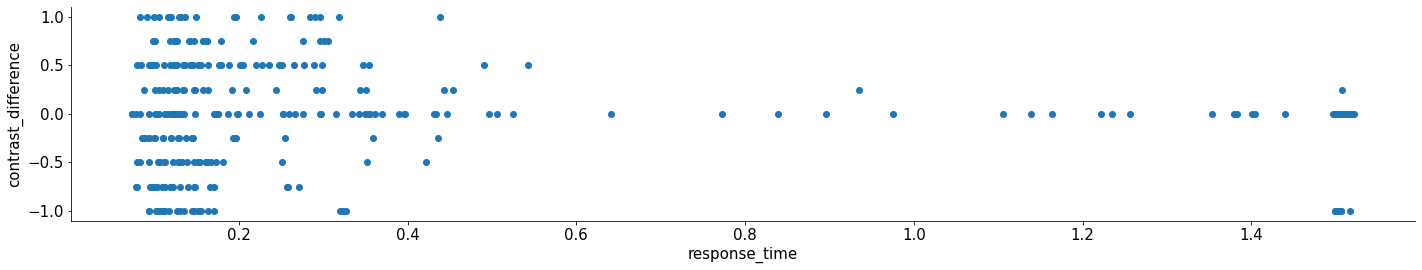

In [ ]:
contrast_difference = contrast_left - contrast_right
plt.scatter(response_time_after_gocue ,contrast_difference)
plt.xlabel('response_time')
plt.ylabel('contrast_difference')

# Comaprison between feedback type before fast/slow response time ( contrast difference = 0 )

**conclousion**: mice respond fast when the previous feedback was 1 and he respond slow when the previous feedback was -1 ( contrast difference= 0 ) 

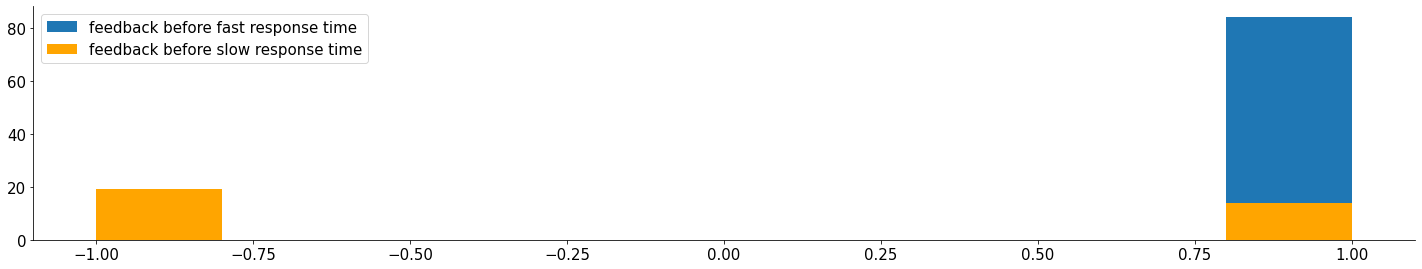

In [ ]:
feedback_before_small = feedback_type[ small_response_time -1  ]
feedback_before_large = feedback_type[ large_response_time -1  ]
plt.hist(feedback_before_small, label= 'feedback before fast response time')
plt.hist(feedback_before_large, label= 'feedback before slow response time', color='Orange')

plt.legend()

# Logistic regression model 

model predict response time state (Fast/Slow) of a mouse-based on feedback type (Reward/No Reward) given to him in the previous trial      

Accuracy:  0.71875


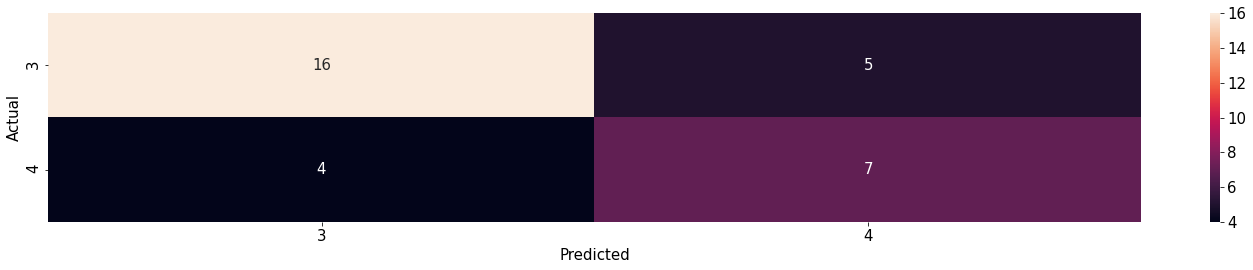

In [ ]:
#"Define our variables"
response_time =dat['response_time']
contrast_left=dat['contrast_left']
contrast_right= dat['contrast_right']
go_cue = dat['gocue']
feedback_type = dat['feedback_type']

response_time= response_time.flatten()
go_cue = go_cue.flatten()

response_time_after_gocue = response_time - go_cue 
contrast_difference = contrast_left - contrast_right


contrast_difference_0 = [ trial for trial in range(len(contrast_difference)) if contrast_difference[trial] == 0 ]
small_response_time = np.array([trail for trail in range(len(response_time_after_gocue[contrast_difference_0])) if response_time_after_gocue[trail] < 0.7 ])
large_response_time = np.array([trail for trail in range(len(response_time_after_gocue[contrast_difference_0])) if response_time_after_gocue[trail] > 0.7 ])


feedback_before_small = feedback_type[ small_response_time -1  ]
feedback_before_large = feedback_type[ large_response_time -1  ]

reward = []
for i in feedback_type:
  if i == -1:
    i = 0
    reward.append(i)
  else:
    reward.append(i)

no_reward = []
for i in feedback_type:
  if i == 1:
    i = 0
    no_reward.append(i)
  else:
    i = 1
    no_reward.append(i)

response_time_state=[]


for i in response_time_after_gocue:
  if i <= 0.7:
    i = 4
    response_time_state.append(i)
  else:
    i = 3
    response_time_state.append(i)

response_time_state = np.array(response_time_state)
reward = np.array(reward)
no_reward = np.array(no_reward)

reward = reward[contrast_difference_0]
no_reward = no_reward[contrast_difference_0]
response_time_state = response_time_state[contrast_difference_0]

contrast_difference_0 = np.array(contrast_difference_0)
contrast_difference_before_cd0 = contrast_difference[contrast_difference_0 - 1 ]

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

mice= {'reward':reward, 'no reward': no_reward,'response_time_state':response_time_state}
df = pd.DataFrame( mice , columns= ['reward', 'no reward','response_time_state'])
X = df[['reward','no reward']]
y= df['response_time_state']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
